# End-to-End Linear Regression Example: California Housing Price Prediction

This notebook demonstrates a complete machine learning lifecycle for a simple linear regression model:
1. Loading data from scikit-learn
2. Exploratory data analysis
3. Data preprocessing
4. Model training
5. Model evaluation
6. Model inference


## 1. Setup and Dependencies

In [1]:
# Install required packages
!conda install scikit-learn pandas numpy matplotlib seaborn

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Loading Data from scikit-learn

We'll use the California housing dataset from scikit-learn, which contains information about housing in California districts.

In [3]:
# Load the dataset from scikit-learn
housing = fetch_california_housing()
print(f"Dataset shape: {housing.data.shape}")

Dataset shape: (20640, 8)


In [4]:
# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseValue'] = housing.target  # Target variable

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [16]:
housing.DESCR.splitlines()

['.. _california_housing_dataset:',
 '',
 'California Housing dataset',
 '--------------------------',
 '',
 '**Data Set Characteristics:**',
 '',
 ':Number of Instances: 20640',
 '',
 ':Number of Attributes: 8 numeric, predictive attributes and the target',
 '',
 ':Attribute Information:',
 '    - MedInc        median income in block group',
 '    - HouseAge      median house age in block group',
 '    - AveRooms      average number of rooms per household',
 '    - AveBedrms     average number of bedrooms per household',
 '    - Population    block group population',
 '    - AveOccup      average number of household members',
 '    - Latitude      block group latitude',
 '    - Longitude     block group longitude',
 '',
 ':Missing Attribute Values: None',
 '',
 'This dataset was obtained from the StatLib repository.',
 'https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html',
 '',
 'The target variable is the median house value for California districts,',
 'expressed in hundreds

## 3. Exploratory Data Analysis

In [17]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Series([], dtype: int64)


In [18]:
# Basic statistics of numerical features
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


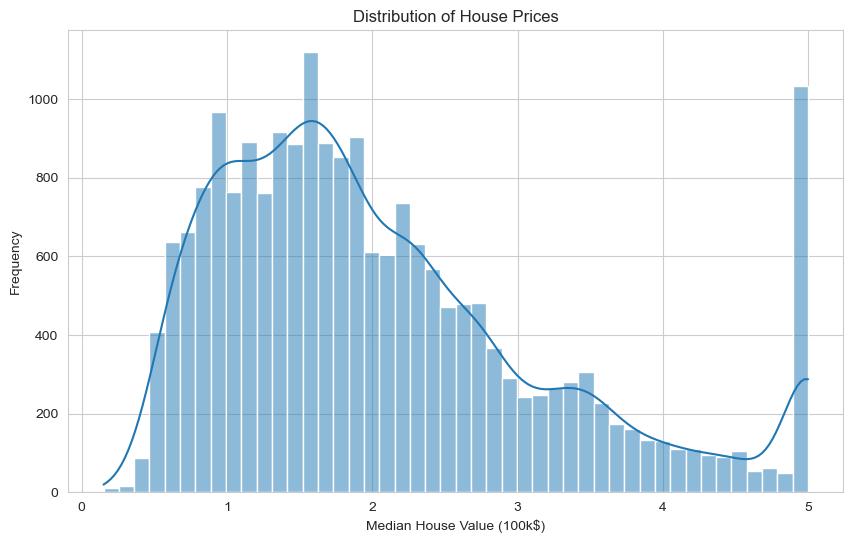

In [19]:
# Distribution of the target variable (MedHouseValue)
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseValue'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Median House Value (100k$)')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Correlation between features and the target
correlation = df.corr()['MedHouseValue'].sort_values(ascending=False)
print("Features correlated with MedHouseValue:")
print(correlation)

Features correlated with MedHouseValue:
MedHouseValue    1.000000
MedInc           0.688075
AveRooms         0.151948
HouseAge         0.105623
AveOccup        -0.023737
Population      -0.024650
Longitude       -0.045967
AveBedrms       -0.046701
Latitude        -0.144160
Name: MedHouseValue, dtype: float64


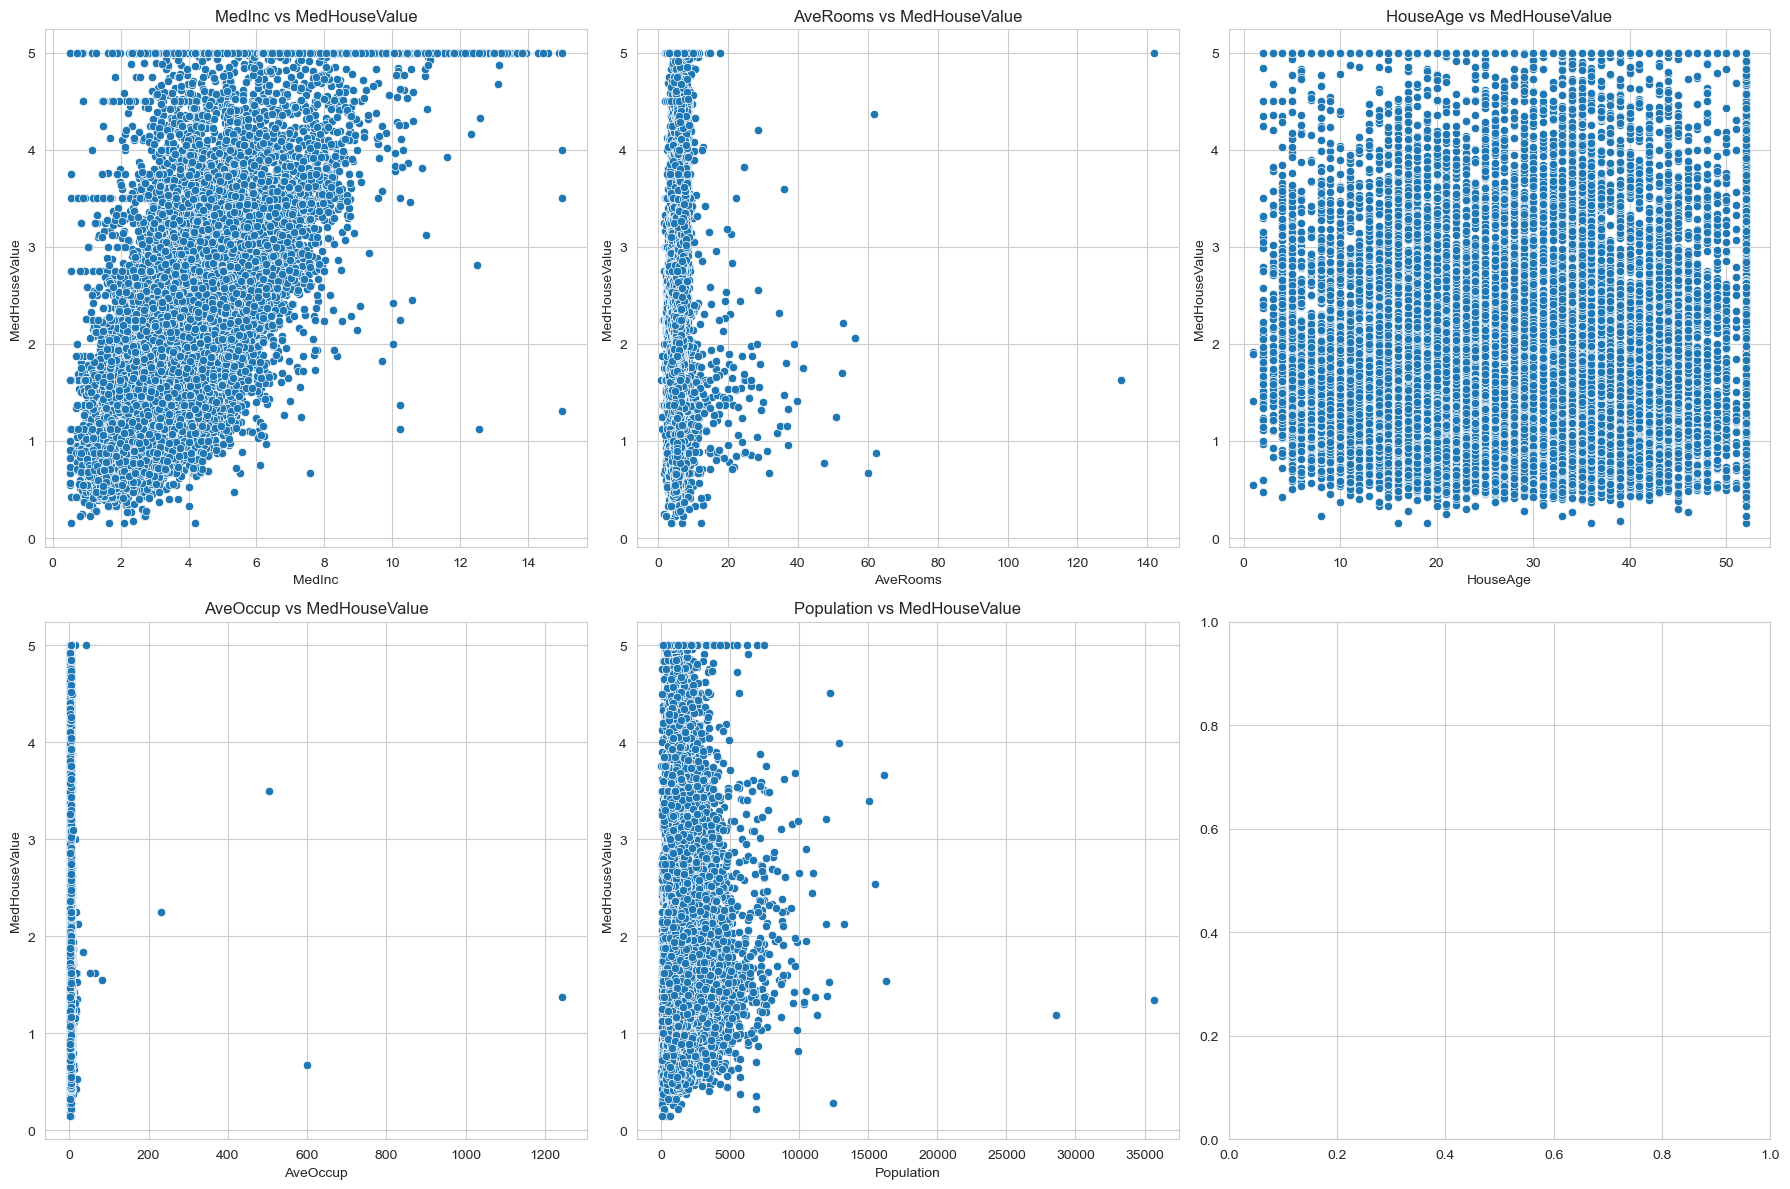

In [21]:
# Visualize the top 5 correlated features with MedHouseValue
top_features = correlation[1:6].index  # Exclude MedHouseValue itself

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.scatterplot(x=feature, y='MedHouseValue', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs MedHouseValue')
    
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [22]:
# Select features based on correlation analysis
# We'll use the top correlated numerical features for simplicity
selected_features = correlation[1:6].index.tolist()
print(f"Selected features: {selected_features}")

# Prepare the data
X = df[selected_features]
y = df['MedHouseValue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Selected features: ['MedInc', 'AveRooms', 'HouseAge', 'AveOccup', 'Population']
Training set shape: (16512, 5)
Testing set shape: (4128, 5)


## 5. Model Training

In [23]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', LinearRegression())  # Linear regression model
])

# Train the model
pipeline.fit(X_train, y_train)

# Get the coefficients
coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

# Display the model coefficients
coef_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
print("Model Coefficients:")
print(coef_df)
print(f"Intercept: {intercept:.2f}")

Model Coefficients:
      Feature  Coefficient
0      MedInc     0.848069
1    AveRooms    -0.063928
2    HouseAge     0.222533
3    AveOccup    -0.050307
4  Population     0.030373
Intercept: 2.07


## 6. Model Evaluation

In [24]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.66
Root Mean Squared Error (RMSE): 0.81
Mean Absolute Error (MAE): 0.60
R² Score: 0.4993


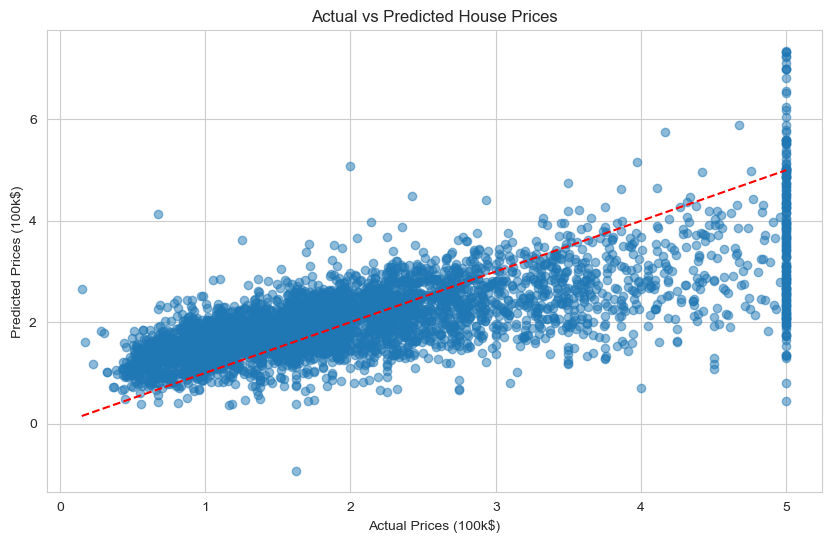

In [25]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices (100k$)')
plt.ylabel('Predicted Prices (100k$)')
plt.title('Actual vs Predicted House Prices')
plt.show()

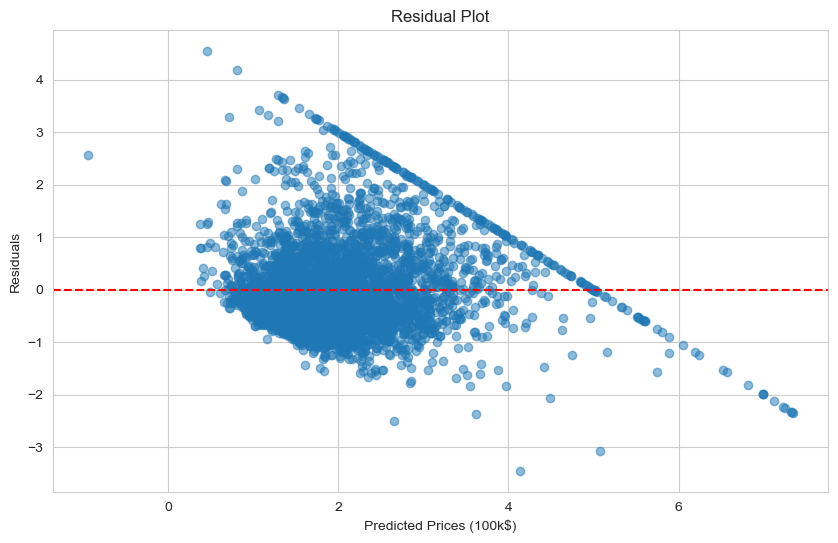

In [26]:
# Plot residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices (100k$)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## 7. Model Inference

Now let's use our trained model to make predictions on new data.

In [27]:
# Create a function for making predictions
def predict_house_price(features_dict):
    # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([features_dict])
    
    # Ensure all required features are present
    for feature in selected_features:
        if feature not in input_df.columns:
            raise ValueError(f"Missing required feature: {feature}")
    
    # Make prediction
    predicted_price = pipeline.predict(input_df[selected_features])[0]
    return predicted_price

In [28]:
# Example: Predict prices for sample houses
# We'll use the median values from our dataset as a starting point
sample_house = {}
for feature in selected_features:
    sample_house[feature] = df[feature].median()

print("Sample house features:")
for feature, value in sample_house.items():
    print(f"{feature}: {value}")

predicted_price = predict_house_price(sample_house)
print(f"\nPredicted house price: ${predicted_price:.2f} (in 100k$)")

Sample house features:
MedInc: 3.5347999999999997
AveRooms: 5.229128787878788
HouseAge: 29.0
AveOccup: 2.818115654360196
Population: 1166.0

Predicted house price: $1.92 (in 100k$)


In [29]:
# Let's try with different values
# Create a more expensive house by increasing the values by 20%
expensive_house = {}
for feature in selected_features:
    expensive_house[feature] = df[feature].median() * 1.2

print("Expensive house features:")
for feature, value in expensive_house.items():
    print(f"{feature}: {value}")

predicted_price = predict_house_price(expensive_house)
print(f"\nPredicted house price: ${predicted_price:.2f} (in 100k$)")

Expensive house features:
MedInc: 4.241759999999999
AveRooms: 6.274954545454546
HouseAge: 34.8
AveOccup: 3.381738785232235
Population: 1399.2

Predicted house price: $2.32 (in 100k$)


In [30]:
# Create a less expensive house by decreasing the values by 20%
cheaper_house = {}
for feature in selected_features:
    cheaper_house[feature] = df[feature].median() * 0.8

print("Cheaper house features:")
for feature, value in cheaper_house.items():
    print(f"{feature}: {value}")

predicted_price = predict_house_price(cheaper_house)
print(f"\nPredicted house price: ${predicted_price:.2f} (in 100k$)")

Cheaper house features:
MedInc: 2.82784
AveRooms: 4.183303030303031
HouseAge: 23.200000000000003
AveOccup: 2.2544925234881568
Population: 932.8000000000001

Predicted house price: $1.53 (in 100k$)


## 8. Conclusion

In this notebook, we've demonstrated a complete machine learning lifecycle for a linear regression model to predict house prices:

1. **Data Loading**: We loaded the California housing dataset from scikit-learn.
2. **Exploratory Data Analysis**: We analyzed the dataset to understand its structure and relationships.
3. **Feature Selection**: We selected the most relevant features based on correlation with the target variable.
4. **Data Preprocessing**: We split the data and standardized the features.
5. **Model Training**: We trained a linear regression model using scikit-learn.
6. **Model Evaluation**: We evaluated the model using various metrics (RMSE, MAE, R²).
7. **Model Inference**: We used the trained model to make predictions on new data.

This simple example demonstrates the fundamental steps in a machine learning project. For a real-world application, you might want to consider:
- More sophisticated feature engineering
- Handling categorical variables
- Addressing outliers and missing values more thoroughly
- Trying more complex models
- Implementing cross-validation
- Model deployment strategies